In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from scipy import stats
from collections import defaultdict
import shap
import datetime
import pickle
from sklearn.model_selection import StratifiedKFold

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from math import inf

In [2]:
import sys
sys.path.insert(1, '/Users/yulia/Documents/Repositories/trading_model/utils')
from data_utils import grid_search_params

In [3]:
import os
os.listdir()

['prepare_dataset.py',
 'median_prices.ipynb',
 '__init__.py',
 'predict_lifetime.py',
 '__pycache__',
 'lifetime_models_spec.pkl',
 'choose_model.ipynb',
 '.ipynb_checkpoints']

In [4]:
brand = 'Fendi'
df = pd.read_pickle('../data/%s_refined.pkl' %brand)

In [5]:
max_date = max(df['sc_date'])- datetime.timedelta(days=30)

## Labeling

In [6]:
df = df[-df['lifetime'].isnull()] # remove if lifetime can't be  recognized
df = df[df.apply(lambda x: x['sc_date'] == x['sc_date_first_date'], axis = 1)]

In [7]:
def labelling_model_1(row):
    if row['lifetime'] <= 30 and row['status'] == 'Complete' and row['ever_sold'] == 1:
        return 1.0
    elif row['lifetime'] > 30:
        return 0.0
    else:
        return None

In [8]:
df['label'] = df.apply(lambda x: labelling_model_1(x), axis = 1)
df_copy_test = pd.DataFrame(data=df)

In [9]:
count_df = df[df['sc_date_first_date'] < max_date]

In [10]:
count_df['label'].value_counts()

0.0    17
1.0    13
Name: label, dtype: int64

In [11]:
df = df[-df['label'].isnull()]
df_copy_train = pd.DataFrame(data=df)

In [12]:
df.columns

Index(['bags_brand', 'id', 'sc_date', 'bags_color', 'bags_condition',
       'materials_list', 'bags_price_refined', 'sold_price_refined',
       'retail_price_refined', 'likes', 'size', 'search_tradesy_fendi',
       'search_fendi', 'search_fendi_kan_i', 'sc_date_last_date',
       'sc_date_first_date', 'ever_sold', 'lifetime', 'status',
       'number_similar', 'avg_similar', 'original_to_avg', 'price_to_retail',
       'price_percentile', 'label'],
      dtype='object')

In [13]:
if len(set(df['size'])) > 1: 
    remove_cols = {'bags_brand', 'id', 'sc_date', 'sold_price_refined', 'likes', 'sc_date_first_date',
                                    'sc_date_last_date', 'lifetime', 'status', 'price_percentile', 'label', 'ever_sold'}
    ordinal_cols = ['bags_condition']
    categorical_cols = ['bags_color', 'materials_list', 'size']
else:
    remove_cols =  {'bags_brand', 'id', 'sc_date', 'sold_price_refined', 'likes', 'sc_date_first_date',
                                    'sc_date_last_date', 'lifetime', 'status', 'price_percentile', 'label', 'size', 'ever_sold'}
    ordinal_cols = ['bags_condition']
    categorical_cols = ['bags_color', 'materials_list']

In [14]:
def loo(feature_value, label_value, feature_dict):
    if len(feature_dict[feature_value]) == 1 or feature_value is None:
        return (sum(feature_dict['all']) - label_value) / (len(feature_dict['all']) - 1)
    else:
        return (sum(feature_dict[feature_value]) - label_value) / (len(feature_dict[feature_value]) - 1)

In [15]:
def LOO_encoder(train_df, test_df, categorical_cols, label_col):
    for feature in categorical_cols:
        feature_dict = defaultdict(list)
        for i, row in train_df.iterrows():
            feature_dict[row[feature]].append(row[label_col])
            feature_dict['all'].append(row[label_col])
        train_df['%s_loo'%feature] = train_df.apply(lambda x: loo(x[feature], x[label_col], feature_dict), axis = 1)
        test_df['%s_loo'%feature] = test_df.apply(lambda x: loo(x[feature], x[label_col], feature_dict), axis = 1)
    return train_df, test_df

In [16]:
def OH_encoder(train_df, test_df, ordinal_cols):
    for feature in ordinal_cols:
        feature_states = list(set(train_df[feature]).union(set(test_df[feature])))[:-1]
        for state in feature_states:
            train_df['%s_%s'%(feature,state)] = train_df[feature].map(lambda x: int(x == state))
            test_df['%s_%s'%(feature,state)] = test_df[feature].map(lambda x: int(x == state))
    return train_df, test_df

In [17]:
def refine_cols(cols):
    if brand == 'Chanel':
        for column in ['avg_similar', 'price_to_retail']:
            cols.remove(column)
    elif brand == 'Louis Vuitton':
        for column in ['avg_similar', 'price_to_retail']:
            cols.remove(column)
    elif brand == 'Gucci':
        for column in ['avg_similar']:
            cols.remove(column)
    elif brand == 'Saint Laurent':
        for column in []:
            cols.remove(column)
    elif brand == 'Fendi':
        for column in ['avg_similar']:
            cols.remove(column)
    return cols

In [18]:
models_quality = {'svm':{'t1': 0, 'f0': 0, 'f1': 0, 't0': 0},
                 'lr':{'t1': 0, 'f0': 0, 'f1': 0, 't0': 0},
                 'xgb':{'t1': 0, 'f0': 0, 'f1': 0, 't0': 0},
                 'ensemble':{'t1': 0, 'f0': 0, 'f1': 0, 't0': 0}}

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(df)

5

In [20]:
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': {
        'rbf': {
            'gamma': [0.01, 0.1, 1, 10, 100, 'scale'], 'degree': [1, 2, 3, 4]
        },
    'poly': {
        'degree': [1, 2, 3, 4]}
    }
}

lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': {'l2': {
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
                      },
                'l1': {
        'solver': ['liblinear', 'saga']
                },
                'elasticnet': {
        'solver': ['saga'], 'l1_ratio': [0.1, 0.5, 0.9]
                }
            }
}

xgb_params = {
    "learning_rate"    : [0.1, 0.2, 0.30] ,
    "max_depth"        : [4, 6, 8],
    "min_child_weight" : [1, 2, 3],
    "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
    "colsample_bytree" : [0.6, 0.8, 1]
}

In [21]:
test_results_df = pd.DataFrame()
for train_index, test_index in skf.split(df[list(set(df.columns) - {'label'})], df['label']):
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]
    
    df_train, df_test = LOO_encoder(df_train, df_test, categorical_cols, 'label')
    df_train, df_test = OH_encoder(df_train, df_test, ordinal_cols)
    cols = ['id', 'label'] + list(set(df_train.columns) - \
                            {'bags_color', 'bags_condition', 'materials_list', 'size', 'label'} - remove_cols)
    
    cols = refine_cols(cols)
    
    df_train = df_train[cols]
    df_test = df_test[cols]

    sm = SMOTE(random_state=42)
    X, y = sm.fit_resample(df_train[cols[2:]], df_train['label'])
    
    #support vector machines
    for params in grid_search_params(svm_params):
        print(params)
        svm_clf = svm.SVC(probability=True, **params)
        svm_clf.fit(X, y)
        df_test['svm_%s_pred'%params] = svm_clf.predict(df_test[cols[2:]])
        df_test['svm_%s_prob'%params] = [item[1] for item in svm_clf.predict_proba(df_test[cols[2:]])]
        df_test['svm_%s_prob_false'%params] = [item[0] for item in svm_clf.predict_proba(df_test[cols[2:]])]
    
    # logistic regression
    for params in grid_search_params(lr_params):
        print(params)
        lr_clf = LogisticRegression(**params).fit(X, y)

        df_test['lr_%s_pred'%params] = lr_clf.predict(df_test[cols[2:]])
        df_test['lr_%s_prob'%params] = [item[1] for item in lr_clf.predict_proba(df_test[cols[2:]])]
        df_test['lr_%s_prob_false'%params] = [item[0] for item in lr_clf.predict_proba(df_test[cols[2:]])]
    
    #xgboost
    for params in grid_search_params(xgb_params):
        print(params)    
        xgb_clf = XGBClassifier(**params)
        xgb_clf.fit(X, y)
    
        df_test['xgb_%s_pred'%params] = xgb_clf.predict(df_test[cols[2:]])
        df_test['xgb_%s_prob'%params] = [item[1] for item in xgb_clf.predict_proba(df_test[cols[2:]])]
        df_test['xgb_%s_prob_false'%params] = [item[0] for item in xgb_clf.predict_proba(df_test[cols[2:]])]
        
    test_results_df = test_results_df.append(df_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 10

newton-cg failed to converge. Increase the number of iterations.
newton-cg failed to converge. Increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}
{'solver': 'sag', 'penalty': 'l2', 'C': 0.01}
{'solver': 'sag', 'penalty': 'l2', 'C': 0.1}
{'solver': 'sag', 'penalty': 'l2', 'C': 1}
{'solver': 'sag', 'penalty': 'l2', 'C': 10}
{'solver': 'sag', 'penalty': 'l2', 'C': 100}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.01}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.1}
{'solver': 'saga', 'penalty': 'l2', 'C': 1}
{'solver': 'saga', 'penalty': 'l2', 'C': 10}
{'solver': 'saga', 'penalty': 'l2', 'C': 100}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_w

{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_ra

{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.3}
{'colsampl


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 100, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 100, '

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

{'solver': 'sag', 'penalty': 'l2', 'C': 0.01}
{'solver': 'sag', 'penalty': 'l2', 'C': 0.1}
{'solver': 'sag', 'penalty': 'l2', 'C': 1}
{'solver': 'sag', 'penalty': 'l2', 'C': 10}
{'solver': 'sag', 'penalty': 'l2', 'C': 100}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.01}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.1}
{'solver': 'saga', 'penalty': 'l2', 'C': 1}
{'solver': 'saga', 'penalty': 'l2', 'C': 10}
{'solver': 'saga', 'penalty': 'l2', 'C': 100}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min

{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 8, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 6, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 3, 'max_depth': 4, 'learning_ra

{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2}
{'colsampl


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 10

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}
{'solver': 'sag', 'penalty': 'l2', 'C': 0.01}
{'solver': 'sag', 'penalty': 'l2', 'C': 0.1}
{'solver': 'sag', 'penalty': 'l2', 'C': 1}
{'solver': 'sag', 'penalty': 'l2', 'C': 10}
{'solver': 'sag', 'penalty': 'l2', 'C': 100}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.01}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.1}
{'solver': 'saga', 'penalty': 'l2', 'C': 1}
{'solver': 'saga', 'penalty': 'l2', 'C': 10}
{'solver': 'saga', 'penalty': 'l2', 'C': 100}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.

{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 2, 'max_depth': 4, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 6, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 8, 'learning_ra

{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1}
{'colsampl


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 10

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}
{'solver': 'sag', 'penalty': 'l2', 'C': 0.01}
{'solver': 'sag', 'penalty': 'l2', 'C': 0.1}
{'solver': 'sag', 'penalty': 'l2', 'C': 1}
{'solver': 'sag', 'penalty': 'l2', 'C': 10}
{'solver': 'sag', 'penalty': 'l2', 'C': 100}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.01}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.1}
{'solver': 'saga', 'penalty': 'l2', 'C': 1}
{'solver': 'saga', 'penalty': 'l2', 'C': 10}
{'solver': 'saga', 'penalty': 'l2', 'C': 100}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.

{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.2, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_ra

{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.3}
{'colsampl


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 1, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 10, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 100, 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 100, 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 100, 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 100, 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 100, 'kernel': 'rbf', 'C': 100}
{'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'C': 0.01}
{'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'C': 0.1}
{'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'C': 1}
{'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'C': 10}
{'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'C': 100}
{'degree':

newton-cg failed to converge. Increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.o

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}
{'solver': 'sag', 'penalty': 'l2', 'C': 0.01}
{'solver': 'sag', 'penalty': 'l2', 'C': 0.1}
{'solver': 'sag', 'penalty': 'l2', 'C': 1}
{'solver': 'sag', 'penalty': 'l2', 'C': 10}
{'solver': 'sag', 'penalty': 'l2', 'C': 100}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.01}
{'solver': 'saga', 'penalty': 'l2', 'C': 0.1}


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


{'solver': 'saga', 'penalty': 'l2', 'C': 1}
{'solver': 'saga', 'penalty': 'l2', 'C': 10}
{'solver': 'saga', 'penalty': 'l2', 'C': 100}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight

{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 2, 'max_depth': 4, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 2, 'max_depth': 6, 'learning_ra

{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 8, 'learning_ra

{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.3}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2}
{'colsample_bytree': 1, 'gamma': 0.2, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.3}
{'colsampl

In [22]:
import re
def model_result_stats(df_test, method_col):

    t1 = df_test[df_test.apply(lambda x: x['label'] == 1 and x[method_col] == 1, axis = 1)].shape[0]
    f0 = df_test[df_test.apply(lambda x: x['label'] == 1 and x[method_col] == 0, axis = 1)].shape[0]
    f1 = df_test[df_test.apply(lambda x: x['label'] == 0 and x[method_col] == 1, axis = 1)].shape[0]
    t0 = df_test[df_test.apply(lambda x: x['label'] == 0 and x[method_col] == 0, axis = 1)].shape[0]
    
    model_stats = 0
    if t1 + f1 > 0:
        model_stats += (t1 / (t1 + f1))
    if t0 + f0 > 0:
        model_stats += (t0 / (t0 + f0))
    if t1 + f0 > 0:
        model_stats += (t1 / (t1 + f0))
    if t0 + f1 > 0:
        model_stats += (t0 / (t0 + f1))
    
    return model_stats

In [23]:
def choose_best_model(df, regex:str):
    cols = [col for col in df.columns if re.search(regex, col)]
    best_method = None
    best_metric = 0
    for col in cols:
        col_metric = model_result_stats(df, col)
        if col_metric > best_metric:
            best_metric = col_metric
            best_method = col
    return best_method, best_metric

In [24]:
best_svm, best_svm_metric = choose_best_model(test_results_df, 'svm_(.*)_pred')
best_lr, best_lr_metric = choose_best_model(test_results_df, 'lr_(.*)_pred')
best_xgb, best_xgb_metric = choose_best_model(test_results_df, 'xgb_(.*)_pred')

In [25]:
best_svm_spec = re.search('svm_(.*)_pred', best_svm).group(1)
best_lr_spec = re.search('lr_(.*)_pred', best_lr).group(1)
best_xgb_spec = re.search('xgb_(.*)_pred', best_xgb).group(1)

In [26]:
test_results_df['ensemble_prob'] = test_results_df.apply(lambda x: (x['svm_%s_prob'%best_svm_spec] +
                                                    x['lr_%s_prob'%best_lr_spec] +
                                                    x['xgb_%s_prob'%best_xgb_spec]) / 3, axis = 1)
test_results_df['ensemble_pred'] = test_results_df['ensemble_prob'].apply(lambda x: 0 if x <= 0.5 else 1)
test_results_df['ensemble_prob_false'] = test_results_df['ensemble_prob'].apply(lambda x: 1-x)

In [27]:
def model_result_stats_expanded(model_stats, df_test, method_col):
    print(method_col)
    t1 = df_test[df_test.apply(lambda x: x['label'] == 1 and x[method_col] == 1, axis = 1)].shape[0]
    f0 = df_test[df_test.apply(lambda x: x['label'] == 1 and x[method_col] == 0, axis = 1)].shape[0]
    f1 = df_test[df_test.apply(lambda x: x['label'] == 0 and x[method_col] == 1, axis = 1)].shape[0]
    t0 = df_test[df_test.apply(lambda x: x['label'] == 0 and x[method_col] == 0, axis = 1)].shape[0]
    
    print(t1, f0, f1, t0)
    model_stats[method_col] = [0]
    if t1 + f1 > 0:
        model_stats[method_col][0] += (t1 / (t1 + f1))
    if t0 + f0 > 0:
        model_stats[method_col][0] += (t0 / (t0 + f0))
    if t1 + f0 > 0:
        model_stats[method_col][0] += (t1 / (t1 + f0))
    if t0 + f1 > 0:
        model_stats[method_col][0] += (t0 / (t0 + f1))

    print(t1/(t1+f1))
    print(t0/(t0+f0))
    print(t1/(t1+f0))
    print(t0/(t0+f1))
    model_stats[method_col].append(t1/(t1+f1))
    model_stats[method_col].append(t0/(t0+f0))
    
    return model_stats

In [28]:
test_results_df.shape

(33, 1653)

In [29]:
model_stats = {}

model_stats = model_result_stats_expanded(model_stats, test_results_df, best_svm)
model_stats = model_result_stats_expanded(model_stats, test_results_df, best_lr)
model_stats = model_result_stats_expanded(model_stats, test_results_df, best_xgb)
model_stats = model_result_stats_expanded(model_stats, test_results_df, 'ensemble_pred')

svm_{'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'C': 0.01}_pred
16 0 15 2
0.5161290322580645
1.0
1.0
0.11764705882352941
lr_{'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}_pred
8 8 6 11
0.5714285714285714
0.5789473684210527
0.5
0.6470588235294118
xgb_{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}_pred
15 1 3 14
0.8333333333333334
0.9333333333333333
0.9375
0.8235294117647058
ensemble_pred
8 8 6 11
0.5714285714285714
0.5789473684210527
0.5
0.6470588235294118


In [30]:
best_method = [method for method in model_stats.keys() if
 model_stats[method][0] == max([model_stats[method][0] for method in model_stats.keys()])][0]
best_precision_1 = model_stats[best_method][1]
best_precision_0 = model_stats[best_method][2]

In [31]:
df_train, df_test = LOO_encoder(df_copy_train, df_copy_test, categorical_cols, 'label')
df_train, df_test = OH_encoder(df_copy_train, df_copy_test, ordinal_cols)

encoded_df = df_train[:]
cols = ['label'] + list(set(df_train.columns) - \
                        {'bags_color', 'bags_condition', 'materials_list', 'size', 'label'} - remove_cols)
cols = refine_cols(cols)
    
df_train = df_train[cols]

X, y = df_train[cols[1:]], df_train['label']

if best_method.startswith('svm'):
    params = eval(best_svm_spec)
    clf = svm.SVC(probability=True, **params).fit(X, y)
elif best_method.startswith('lr'):
    params = eval(best_lr_spec)
    clf = LogisticRegression(**params).fit(X, y)
elif best_method.startswith('xgb'):
    params = eval(best_xgb_spec)
    clf = XGBClassifier(**params).fit(X, y)
xgb_clf = clf

In [32]:
best_method

"xgb_{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}_pred"

In [33]:
with open('lifetime_models_spec.pkl', 'rb') as file:
    models_dict = pickle.load(file)
models_dict[brand] = {'name': best_method, 'model': clf, 'df_train': df_train, 'df_test': df_test, 'features':cols[1:],
                      'precision_class1': best_precision_1, 'precision_class0': best_precision_0,
                      'test_reults_df': test_results_df, 'encoded_df': encoded_df}
with open('lifetime_models_spec.pkl', 'wb') as file:
    pickle.dump(models_dict,file)

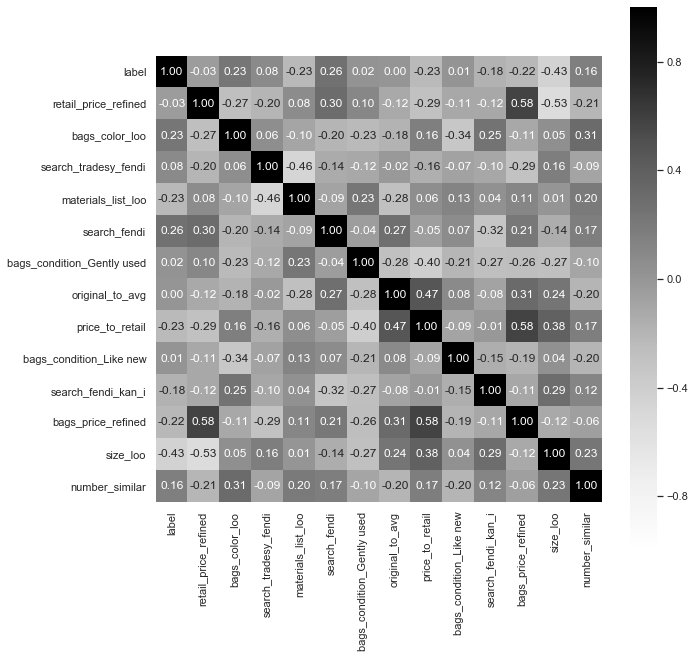

In [34]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(df_train[cols].corr(), annot = True, square=True, fmt='.2f', vmin=-1, vmax=1, center= 0, cmap= 'Greys')


# ROC curves

In [35]:
import warnings
warnings.filterwarnings("ignore")

# load libraries
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [36]:
# Get predicted probabilities
y_score1 = test_results_df['svm_%s_prob_false'%best_svm_spec]
y_score2 = test_results_df['lr_%s_prob_false'%best_lr_spec]
y_score3 = test_results_df['xgb_%s_prob_false'%best_xgb_spec]
y_score4 = test_results_df['ensemble_prob_false']

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_results_df['label'], y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(test_results_df['label'], y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(test_results_df['label'], y_score3)
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(test_results_df['label'], y_score4)
print('roc_auc_score for Support Vector Machines: ', roc_auc_score(test_results_df['label'], y_score1))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(test_results_df['label'], y_score2))
print('roc_auc_score for XGBoost: ', roc_auc_score(test_results_df['label'], y_score3))
print('roc_auc_score for Ensemble: ', roc_auc_score(test_results_df['label'], y_score4))

roc_auc_score for Support Vector Machines:  0.5220588235294117
roc_auc_score for Logistic Regression:  0.6029411764705882
roc_auc_score for XGBoost:  0.0772058823529412
roc_auc_score for Ensemble:  0.25735294117647056


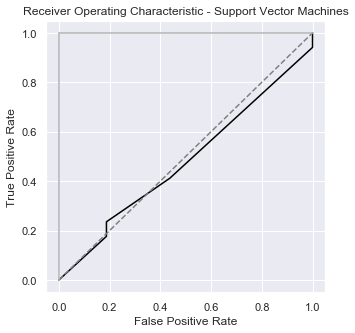

In [37]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Support Vector Machines')
plt.plot(true_positive_rate1, false_positive_rate1, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

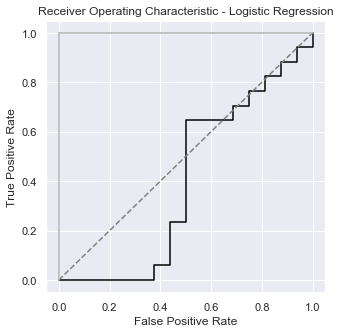

In [38]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(true_positive_rate2, false_positive_rate2, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

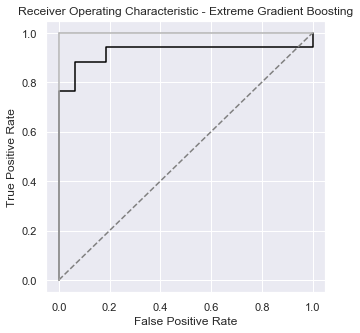

In [39]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Extreme Gradient Boosting')
plt.plot(true_positive_rate3, false_positive_rate3, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

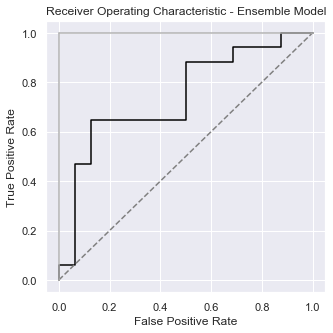

In [40]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Ensemble Model')
plt.plot(true_positive_rate4, false_positive_rate4, color='Black')
plt.plot([0, 1], ls="--", color='Grey')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Shap

In [41]:
shap.initjs()

In [42]:
xgb_clf

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [43]:
explainer = shap.TreeExplainer(xgb_clf)

In [44]:
shap_values = explainer.shap_values(X.as_matrix())

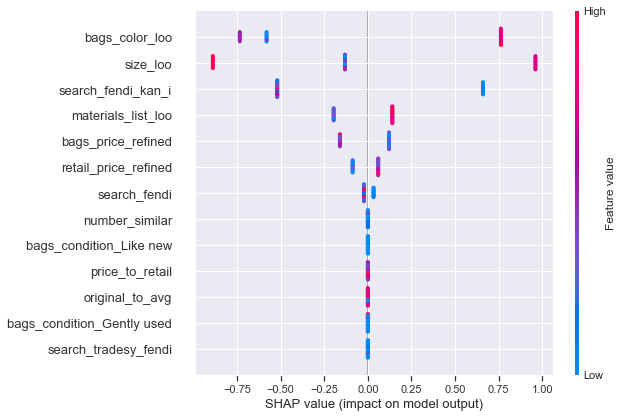

In [45]:
shap.summary_plot(shap_values, X)

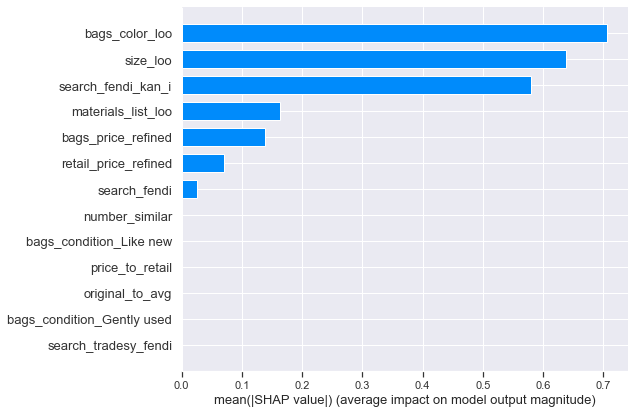

In [46]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [47]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [48]:
shap.force_plot(explainer.expected_value, shap_values, X)

In [49]:
print(best_method)

xgb_{'colsample_bytree': 0.8, 'gamma': 0.4, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1}_pred
